# Optimization

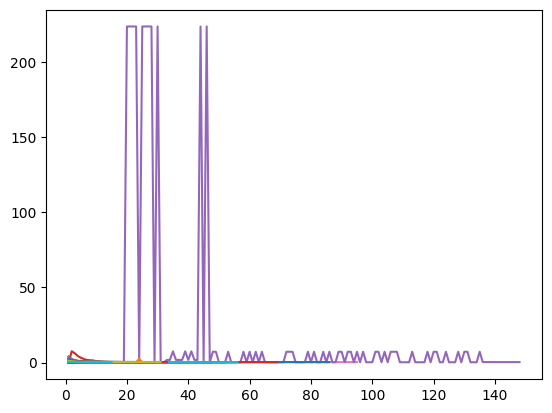

optimal design variable:
   capture_width      28.697 [m]
   pen_diameter       25.277 [m]
   pen_height          8.710 [m]
   spacing           101.226 [m]
   stock_density      30.000 [kg/m^3]
   pen_depth          90.901 [m]
----------------------------------------
optimal objective function terms:
   cost_per_yield      0.312 [$/kg]
   price          2502654.323 [$]
   fish_yield     8024768.553 [kg]
----------------------------------------


In [6]:
import modules
import numpy as np
import importlib
importlib.reload(modules)
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from functools import partial
from numdifftools import Jacobian, Hessian


def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

class OpObj(object):
    def __init__(self, bnds, x_name, p):
        self.x_name, self.p = x_name, p
        x0 = []
        for i in range(len(bnds)):
            x0.append(np.random.uniform(low=bnds[i][0], high=bnds[i][1]))
        self.x0 = x0
        self.f = np.full(shape=(500,), fill_value=np.NaN)
        self.ineq = np.full(shape=(500,2), fill_value=np.NaN)
        self.eq = np.full(shape=(500,0), fill_value=np.NaN)
        self.count = 0
        
    def obj_fun(self, x):
        return obj_fun(x, self.x_name, self.p)

def cb(xk, obj=None):
    obj.f[obj.count] = obj.obj_fun(xk)
    obj.ineq[obj.count] = modules.ineq_constraint(x0, x_name, p)
    obj.eq[obj.count] = modules.eq_constraint(x0, x_name, p)
    obj.count += 1

    
# simulation
def obj_fun(x0, x_name, p):
    return modules.obj(x0, x_name, p)

def hess_fun(x, x_name, p):
    return Hessian(lambda x: obj_fun(x, x_name, p))(x)

def jac_fun(x, x_name, p):
    return Jacobian(lambda x: obj_fun(x, x_name, p))(x).ravel()

def gradient_respecting_bounds(bounds, fun, eps=1e-8):
    """bounds: list of tuples (lower, upper)"""
    def gradient(x, x_name, p):
        fx = fun(x, x_name, p)
        grad = np.zeros(len(x))
        for k in range(len(x)):
            d = np.zeros(len(x))
            d[k] = eps if x[k] + eps <= bounds[k][1] else -eps
            grad[k] = (fun(x + d, x_name, p) - fx) / d[k]
        return grad
    return gradient


# design variables
x_name = ['x_wec','x_pen']
x_list = modules.variable_lookup(x_name)
x_list_default_values = modules.default_values(x_name)
x_list_bnds_values = modules.bnds_values(x_name)
x0 = []
x0_unit = []
x0_bnds = []
for i in range(len(x_list)):
    x0.append(x_list_default_values[x_list[i]][0])
    x0_unit.append(x_list_default_values[x_list[i]][1])
    x0_bnds.append(x_list_bnds_values[x_list[i]])

# parameters
wec_types = ['point absorber'] #['attenuator','terminator','point absorber']

# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_wec','p_fish_salmon']

default_vars = []
for i in range(len(all_vars)):
    if all_vars[i] not in x_name:
        default_vars.append(all_vars[i])

p_list = modules.variable_lookup(default_vars)
p_list_default_values = modules.default_values(default_vars)
p = {}
p_unit = []
for i in range(len(p_list)):
    p[p_list[i]] = p_list_default_values[p_list[i]][0]
    p_unit.append(p_list_default_values[p_list[i]][1])


#optimization
fig, ax = plt.subplots(1,1)
opt_idx = 0
res={}
opt_res_history = []
iteration_history = []

for i in range(len(wec_types)):
    p['wec_type'] = wec_types[i]
    
    iteration = np.linspace(1,500,500)
    
    for n_test in range(100):
        op_obj = OpObj(x0_bnds, x_name, p)    

        arguments = (x_name, p)

        cons = ({'type': 'ineq', 'fun': modules.ineq_constraint, 'args': arguments},
                {'type': 'eq', 'fun': modules.eq_constraint, 'args': arguments})
        
        options={"maxiter":5000}
        
        res[i] = minimize(obj_fun, op_obj.x0, 
                          args=arguments, 
                          method='SLSQP', 
                          hess=hess_fun,
                          #jac=jac_fun,
                          jac=gradient_respecting_bounds(x0_bnds, obj_fun),
                          bounds=x0_bnds, 
                          constraints=cons, 
                          tol=1e-8,
                          options=options,
                          callback=partial(cb, obj=op_obj))

        if res[i].fun < res[opt_idx].fun:
            opt_idx = i
            
        ax.plot(iteration, op_obj.f)
        
        opt_res_history.append(op_obj.f)
        iteration_history.append(op_obj.count)

#ax.set_ylim((0.339,0.340))
plt.show()

col_width = len(max(x_list, key=len))
print_bold("optimal design variable:")
for i in range(len(x_list)):
    print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res[opt_idx].x[i]), x0_unit[i])
print("-"*40)

print_bold("optimal objective function terms:")
cost_per_yield, price, fish_yield = modules.obj_terms(res[opt_idx].x, x_name, p)
print(' '*2, "cost_per_yield", "{:10.3f}".format(cost_per_yield), '[$/kg]')
print(' '*2, "price         ", "{:10.3f}".format(price), '[$]')
print(' '*2, "fish_yield    ", "{:10.3f}".format(fish_yield), '[kg]')
print("-"*40)

# Plot fish growth and fish oxygen demand

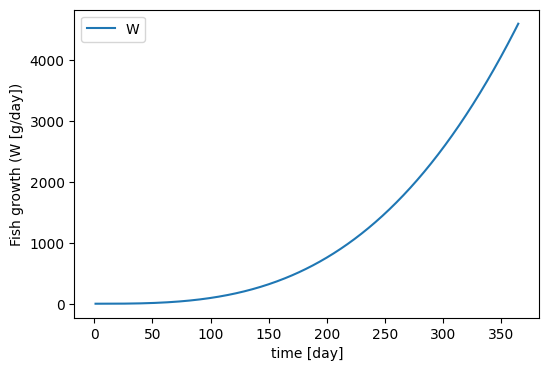

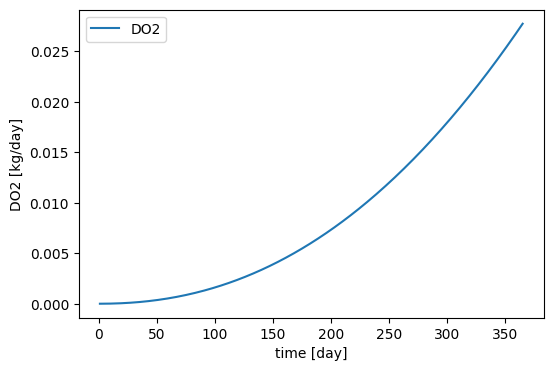

In [7]:
x_opt = res[opt_idx].x
modules.plot_variable(x_opt, x_name, p)

# Plot objective function and constraints

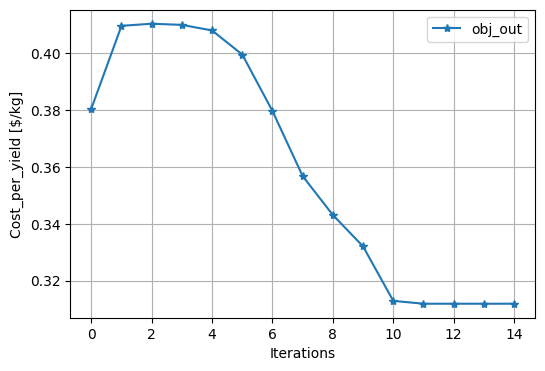

In [8]:
total_iter = op_obj.count
obj_out = np.zeros(total_iter)
obj_ineq_const = np.zeros([total_iter,len(op_obj.ineq[0])])
for i in range(total_iter):
    obj_out[i] = op_obj.f[i]
    obj_ineq_const[i] = op_obj.ineq[i]
    
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(obj_out, label='obj_out', marker='*')
ax.set(xlabel='Iterations', ylabel='Cost_per_yield [$/kg]')
ax.legend()
ax.grid(True)

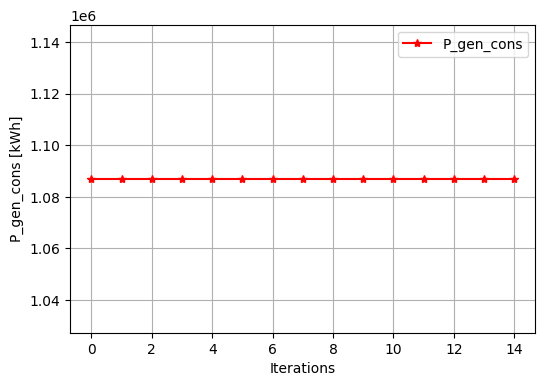

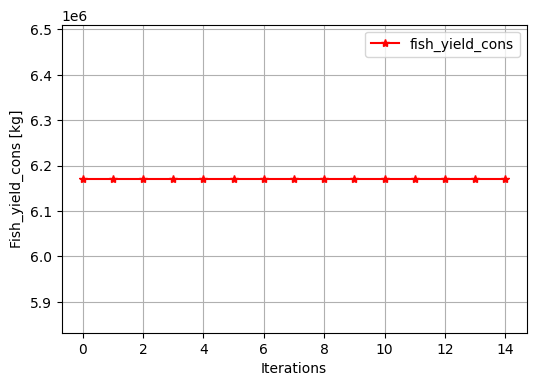

In [9]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(obj_ineq_const[:,0], 'r', label='P_gen_cons', marker='*')
ax.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
ax.legend()
ax.grid(True)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(obj_ineq_const[:,1], 'r', label='fish_yield_cons', marker='*')
ax.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
ax.legend()
ax.grid(True)